# Developing the classifiers

## Retrieving cosine similarities

In [1]:
import sys
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing


def get_cosim(dev_dict):
    """
    Calculates cosine similarity for each t-h pair in a dev set.
    
    :param dev_dict: an inference dict
    :return: list of all cosine similarities
    """
    sims = []
    for feats in dev_dict.values():
        t_tokens = feats['t'].split()
        h_tokens = feats['h'].split()

        # Convert e.g. 'volleybal' in t to 'bal' in t if 'bal' in h
        for h_token in h_tokens:
            for i, t_token in enumerate(t_tokens):
                if h_token != t_token and h_token in t_token:
                    t_tokens[i] = h_token
            
        # Create BoW
        th_tokens = set(t_tokens + h_tokens)
        t_vector = [t_tokens.count(th_token) for th_token in th_tokens]
        h_vector = [h_tokens.count(th_token) for th_token in th_tokens]
        t_vector = preprocessing.normalize([t_vector], norm='l2')
        h_vector = preprocessing.normalize([h_vector], norm='l2')
            
        # Calculate cosine similarity
        cosim = round(cosine_similarity(t_vector, h_vector).item(), 3)
        if ('geen' in t_tokens or 'niet' in t_tokens) and not \
          ('geen' in h_tokens or 'niet' in h_tokens) or \
          ('geen' in h_tokens or 'niet' in h_tokens) and not \
          ('geen' in t_tokens or 'niet' in t_tokens):
            cosim = 0
        sims.append(cosim)
                
    return(sims)

### Preprocessing SICK-NL
As performed by the `preprocess` function.

In [2]:
def preprocess(doc, nlp):
    """
    Removes punctuation and stopwords and lemmatises words.

    :param doc: document string
    :param nlp: SpaCy pipeline
    :return: the preprocessed document
    """
    
    nlp.Defaults.stop_words -= {"geen", "niet"}
    doc = nlp(doc)
    cleaned = []
    for token in doc:
        if not token.is_punct and token.lemma_ not in nlp.Defaults.stop_words:
            cleaned.append(token.lemma_)
    return " ".join(cleaned)

In [3]:
import pickle
import spacy

nlp = spacy.load('nl_core_news_lg')

### Preprocessing SICK-NL

In [4]:
dev_dict_sicknl = pickle.load(open("../data/sicknl/dev.p", "rb"))
test_dict_sicknl = pickle.load(open("../data/sicknl/test.p", "rb"))

for pair_id, feats in dev_dict_sicknl.items():
    dev_dict_sicknl[pair_id]['t'] = preprocess(feats['t'], nlp)
    dev_dict_sicknl[pair_id]['h'] = preprocess(feats['h'], nlp)
    
for pair_id, feats in test_dict_sicknl.items():
    test_dict_sicknl[pair_id]['t'] = preprocess(feats['t'], nlp)
    test_dict_sicknl[pair_id]['h'] = preprocess(feats['h'], nlp)

### Preprocessing RTE-3

In [5]:
dev_dict_rte3 = pickle.load(open("../data/rte3/dev.p", "rb"))
test_dict_rte3 = pickle.load(open("../data/rte3/test.p", "rb"))

for pair_id, feats in dev_dict_rte3.items():
    dev_dict_rte3[pair_id]['t'] = preprocess(feats['t'], nlp)
    dev_dict_rte3[pair_id]['h'] = preprocess(feats['h'], nlp)
    
for pair_id, feats in test_dict_rte3.items():
    test_dict_rte3[pair_id]['t'] = preprocess(feats['t'], nlp)
    test_dict_rte3[pair_id]['h'] = preprocess(feats['h'], nlp)

### Merging SICK-NL and RTE-3

In [6]:
# Handle conflicting keys
dev_dict_merged = dict()
length = 0
for feats in dev_dict_rte3.values():
    dev_dict_merged[length+1] = feats
    length += 1
for feats in dev_dict_sicknl.values():
    dev_dict_merged[length+1] = feats
    length += 1

# Handle conflicting keys
test_dict_merged = dict()
length = 0
for feats in test_dict_rte3.values():
    test_dict_merged[length+1] = feats
    length += 1
for feats in test_dict_sicknl.values():
    test_dict_merged[length+1] = feats
    length += 1

In [7]:
cosims_sicknl_dev = get_cosim(dev_dict_sicknl)
cosims_rte3_dev = get_cosim(dev_dict_rte3)
cosims_merged_dev = get_cosim(dev_dict_merged)

cosims_sicknl_test = get_cosim(test_dict_sicknl)
cosims_rte3_test = get_cosim(test_dict_rte3)
cosims_merged_test = get_cosim(test_dict_merged)

## Retrieving dependency similarities

### Retrieving dependencies and tokens
Dependencies and tokens are added to the inference dicts for faster looping.

In [8]:
def append_dict(nlp, inference_dict):
    """
    Adds four key-value pairs to each pair in the inference_dict: for both
    documents 1) a lowered and tokenised version and 2) its dependencies.

    :param nlp: SpaCy pipeline
    :param inference_dict: an inference dict
    :return: the appended inference dict
    """
    for pair_id, entry in inference_dict.items():
        t_doc = nlp(entry['t'])
        h_doc = nlp(entry['h'])

        inference_dict[pair_id]['t_tokens'] = [token.text.lower() for sent in t_doc.sents for token in sent]
        inference_dict[pair_id]['h_tokens'] = [token.text.lower() for sent in h_doc.sents for token in sent]
        inference_dict[pair_id]['t_deps'] = [(token.lemma_, token.dep_, token.head.lemma_) for token in t_doc]
        inference_dict[pair_id]['h_deps'] = [(token.lemma_, token.dep_, token.head.lemma_) for token in h_doc]
                
    return(inference_dict)

In [9]:
import spacy
import pickle


nlp = spacy.load('nl_core_news_lg')

dev_dict_sicknl = pickle.load(open("../data/sicknl/dev.p", "rb"))
test_dict_sicknl = pickle.load(open("../data/sicknl/test.p", "rb"))
dev_dict_rte3 = pickle.load(open("../data/rte3/dev.p", "rb"))
test_dict_rte3 = pickle.load(open("../data/rte3/test.p", "rb"))

# Handle duplicate keys while merging SICK-NL and RTE-3
length = 1
dev_dict_merged = dict()
for feats in dev_dict_sicknl.values():
    dev_dict_merged[length] = feats
    length += 1
for feats in dev_dict_rte3.values():
    dev_dict_merged[length] = feats
    length += 1
    
length = 1
test_dict_merged = dict()
for feats in test_dict_sicknl.values():
    test_dict_merged[length] = feats
    length += 1
for feats in test_dict_rte3.values():
    test_dict_merged[length] = feats
    length += 1
    
dev_dict_sicknl = append_dict(nlp, dev_dict_sicknl)
test_dict_sicknl = append_dict(nlp, test_dict_sicknl)
dev_dict_rte3 = append_dict(nlp, dev_dict_rte3)
test_dict_rte3 = append_dict(nlp, test_dict_rte3)
dev_dict_merged = append_dict(nlp, dev_dict_merged)
test_dict_merged = append_dict(nlp, test_dict_merged)

### Defining possible overlap paths
Matching rules consist of two comparisons: both between 1) the lemmas and 2) the relations. First, 6 functions are build to define 6 possible paths:

In [10]:
"""
6 paths to compare words. Note that a match is positive if a word in the hypothesis is
a substring of the word in the text (e.g. volleybal = bal).

:param dep_t: one of the dependency triplets in the text (tuple)
:param dep_h: one of the dependency triplets in the hypothesis (tuple)
:return: True if it is a match, False otherwise
"""
def linear_full_overlap(dep_t, dep_h):
    """Checks whether both the head and dependent of the triplets match."""
    return (dep_h[0] in dep_t[0]) and (dep_h[2] in dep_t[2])


def linear_head_overlap(dep_t, dep_h):
    """Checks whether the heads of the triplets match."""
    return dep_h[2] in dep_t[2]


def linear_dependent_overlap(dep_t, dep_h):
    """Checks whether the dependents of the triplets match."""
    return dep_h[0] in dep_t[0]


def cross_full_overlap(dep_t, dep_h):
    """Checks whether the dependent and head in the hypthesis triplet respectively 
    matches the head and dependent in the text triplet."""
    return (dep_h[2] in dep_t[0]) and (dep_h[0] in dep_t[2])


def cross_partial_overlap_1(dep_t, dep_h):
    """Checks whether the dependent in the text triplet matches the head in the hypthesis triplet."""
    return dep_h[2] in dep_t[0]


def cross_partial_overlap_2(dep_t, dep_h):
    """Checks whether the head in the text triplet matches the dependent in the hypthesis triplet."""
    return dep_h[0] in dep_t[2]

### Applying rules
Subsequently, a function that combines both comparisons is build. The relations to compare are yet to be defined.

In [11]:
def apply_rule(t_deps, dep_h, rel_rels, overlap_func):
    """
    Checks whether the relations match and the words match according to the specified overlap path.
    
    :param t_deps: a list of all dependency triples (tuples) in the text
    :parm dep_h: the current (i.e. to be checked) dependency triple (tuple) in the hypothesis
    :param rel_rels: order independent list of two lists containing related relations 
                    (e.g. [['nmod'], ['obj', 'nsubj']])
    :param overlap_func: func of the corresponding overlap pattern
    :return: True if a match is found, False otherwise
    """
    # one direction, e.g. H(Y, 'nmod', X) and and T(X, 'obj', Y)
    if dep_h[1] in rel_rels[0]:
        for dep_t in t_deps:
            if dep_t[1] in rel_rels[1] and overlap_func(dep_t, dep_h):
                    return True
    
    # opposite direction, e.g. H(X, 'obj', Y) and and T(Y, 'nmod', X)
    elif dep_h[1] in rel_rels[1]:
        for dep_t in t_deps:
            if dep_t[1] in rel_rels[0] and overlap_func(dep_t, dep_h):
                return True

    else:
        return False

### Preprocessing triplets
Several processing steps have been tested that could increase accuracy for both corpora. Only removing relations has been preserved.

In [12]:
def process_deps(entry):
    """
    Processes the appended inference dict by removing relations that lower accuracy.
    
    :param entry: value in the inference dict
    :return: the processed dependencies for both the text and hypothesis
    """

    # Remove insignificant rels
    insignificant = ('ROOT', 'aux:pass', 'aux', 'punct')
    t_deps = [dep_t for dep_t in entry['t_deps'] if dep_t[1] not in insignificant]
    h_deps = [dep_h for dep_h in entry['h_deps'] if dep_h[1] not in insignificant]
                    
    return t_deps, h_deps

In [13]:
def get_depsim(rules, dev_dict):
    """
    Reports accuracy of a given threshold for the system on a test set.
    
    :param rules: list where list [0] is an order independent list of two lists containing equivalent relations 
                  (e.g. [['nmod'], ['obj', 'nsubj']]) and list[1] is the func of the corresponding overlap pattern
    :param dev_dict: an inference dict
    """
    scores = []
    for entry in dev_dict.values():
        score = 0
        t_deps, h_deps = process_deps(entry)

        # Apply rules
        for dep_h in h_deps:
            # Apply custom rule 4 (negation)
            if ('geen' in entry['t_tokens'] or 'niet' in entry['t_tokens']) and not \
               ('geen' in entry['h_tokens'] or 'niet' in entry['h_tokens']) or \
               ('geen' in entry['h_tokens'] or 'niet' in entry['h_tokens']) and not \
               ('geen' in entry['t_tokens'] or 'niet' in entry['t_tokens']):
                score = 0
                break
                
            # Apply custom rule 3 (aan het ..)
            if 'aan het' in ' '.join(entry['t_tokens']) or 'aan het' in ' '.join(entry['h_tokens']):
                if apply_rule(t_deps, dep_h, [['nmod'], ['obj']], cross_full_overlap):
                    score += 1
                    continue
            
            # Apply manual rules
            for rule in rules:
                if apply_rule(t_deps, dep_h, rule[0], rule[1]):
                    score += rule[2]
                    break

        scores.append(round(score / (len(h_deps)), 3))
    
    return scores

In [14]:
rules_sicknl = pickle.load(open("../data/rules/sicknl.p", "rb"))
rules_rte3 = pickle.load(open("../data/rules/rte3.p", "rb"))
rules_merged = pickle.load(open("../data/rules/merged.p", "rb"))

In [15]:
depsims_sicknl_dev = get_depsim(rules_sicknl, dev_dict_sicknl)
depsims_rte3_dev = get_depsim(rules_rte3, dev_dict_rte3)
depsims_merged_dev = get_depsim(rules_merged, dev_dict_merged) 

depsims_sicknl_test = get_depsim(rules_sicknl, test_dict_sicknl)
depsims_rte3_test = get_depsim(rules_rte3, test_dict_rte3)
depsims_merged_test = get_depsim(rules_merged, test_dict_merged)

## Retrieving gold labels

In [16]:
def get_gold(dev_dict):
    """
    Retrieves gold labels (0 for no and 1 for yes) of an inference dict
    
    :param dev_dict: an inference dict
    return: list of gold labels
    """
    
    labels = []
    for entry in dev_dict.values():
        if entry['entailment_label'] == 'NO':
            labels.append(0)
        else:
            labels.append(1)
            
    return labels

In [17]:
gold_sicknl_train = get_gold(dev_dict_sicknl)
gold_rte3_train = get_gold(dev_dict_rte3)
gold_merged_train = get_gold(dev_dict_merged)

gold_sicknl_test = get_gold(test_dict_sicknl)
gold_rte3_test = get_gold(test_dict_rte3)
gold_merged_test = get_gold(test_dict_merged)

## Combining similarities 

In [18]:
vectors_sicknl_train, vectors_rte3_train = [], []
for splits in [[cosims_sicknl_dev, depsims_sicknl_dev, vectors_sicknl_train], 
               [cosims_rte3_dev, depsims_rte3_dev, vectors_rte3_train]]:
    for i in range(len(splits[0])):
        splits[2].append([splits[0][i], splits[1][i]])

vectors_sicknl_test, vectors_rte3_test = [], []
for splits in [[cosims_sicknl_test, depsims_sicknl_test, vectors_sicknl_test], 
               [cosims_rte3_test, depsims_rte3_test, vectors_rte3_test]]:
    for i in range(len(splits[0])):
        splits[2].append([splits[0][i], splits[1][i]])
        
vectors_merged_train = vectors_sicknl_train + vectors_rte3_train
vectors_merged_test = vectors_sicknl_test + vectors_rte3_test

## Training and evaluating classifiers

In [19]:
from sklearn import metrics

def train_classifiers(clf, params):
    """
    Trains the given classifier model on dev sets.
    
    :param clf: sklearn class of the classifiers
    :params: dictionary with params names (str) as keys and lists of parameter settings to try as values
    :returns: trained classifier models
    """

    clf_sicknl = GridSearchCV(clf, params, scoring='accuracy')
    clf_sicknl.fit(vectors_sicknl_train, gold_sicknl_train)

    clf_rte3 = GridSearchCV(clf, params, scoring='accuracy')
    clf_rte3.fit(vectors_rte3_train, gold_rte3_train)

    clf_merged = GridSearchCV(clf, params, scoring='accuracy')
    clf_merged.fit(vectors_merged_train, gold_merged_train)

    print("SICK-NL: {} (avg) using {}".format(round(clf_sicknl.score(vectors_sicknl_train, gold_sicknl_train), 3), 
                                              clf_sicknl.best_params_), file=sys.stderr)
    print("RTE-3: {} (avg) using {}".format(round(clf_rte3.score(vectors_rte3_train, gold_rte3_train), 3), 
                                            clf_rte3.best_params_), file=sys.stderr)
    print("Merged: {} (avg) using {}".format(round(clf_merged.score(vectors_merged_train, gold_merged_train), 3), 
                                             clf_merged.best_params_), file=sys.stderr)
    
    return clf_sicknl, clf_rte3, clf_merged

In [20]:
from sklearn.metrics import classification_report

def eval_classifiers(clf_sicknl, clf_rte3, clf_merged, extended=False):
    """
    Prints the evaluation of the given classifiers on the corresponding test sets.
    
    :param clf_sicknl: sklearn class of the classifiers trained on SICK-NL
    :param clf_rte3: sklearn class of the classifiers trained on RTE-3
    :param clf_merged: sklearn class of the classifiers trained on their union
    """    
    print("SICK-NL model:")
    print(classification_report(gold_sicknl_test, clf_sicknl.predict(vectors_sicknl_test), digits=3))
    if extended == True:
        print('Accuracy on RTE-3:', round(accuracy_score(gold_rte3_test, clf_sicknl.predict(vectors_rte3_test)), 3))
        print('Accuracy on merged:', round(accuracy_score(gold_merged_test, clf_sicknl.predict(vectors_merged_test)), 3), '\n')
    
    print("RTE-3 model:")
    print(classification_report(gold_rte3_test, clf_rte3.predict(vectors_rte3_test), digits=3))
    if extended == True:
        print('Accuracy on SICK-NL:', round(accuracy_score(gold_sicknl_test, clf_rte3.predict(vectors_sicknl_test)), 3))
        print('Accuracy on merged:', round(accuracy_score(gold_merged_test, clf_rte3.predict(vectors_merged_test)), 3), '\n')
    
    print("Merged model:")
    print(classification_report(gold_merged_test, clf_merged.predict(vectors_merged_test), digits=3))
    if extended == True:
        print('Accuracy on SICK-NL:', round(accuracy_score(gold_sicknl_test, clf_rte3.predict(vectors_sicknl_test)), 3))
        print('Accuracy on RTE-3:', round(accuracy_score(gold_rte3_test, clf_merged.predict(vectors_rte3_test)), 3), '\n')

In [21]:
from sklearn.model_selection import GridSearchCV

### Gaussian naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB
clf_sicknl, clf_rte3, clf_merged = train_classifiers(GaussianNB(), params={})

SICK-NL: 0.799 (avg) using {}
RTE-3: 0.646 (avg) using {}
Merged: 0.751 (avg) using {}


In [23]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.798     0.757     0.777       564
           1      0.769     0.809     0.788       564

    accuracy                          0.783      1128
   macro avg      0.784     0.783     0.783      1128
weighted avg      0.784     0.783     0.783      1128

RTE-3 model:
              precision    recall  f1-score   support

           0      0.581     0.641     0.610       156
           1      0.600     0.538     0.568       156

    accuracy                          0.590       312
   macro avg      0.591     0.590     0.589       312
weighted avg      0.591     0.590     0.589       312

Merged model:
              precision    recall  f1-score   support

           0      0.719     0.762     0.740       720
           1      0.747     0.701     0.723       720

    accuracy                          0.732      1440
   macro avg      0.733     0.732     0.732      1440
weighted avg      0.733     0.73

### SVMs

In [24]:
from sklearn import svm

params = {'C': [0.5, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100],
          'kernel': ('linear', 'rbf'),
          'random_state': [1]
         }

clf = svm.SVC()
clf_sicknl, clf_rte3, clf_merged = train_classifiers(clf, params)

SICK-NL: 0.799 (avg) using {'C': 1, 'kernel': 'linear', 'random_state': 1}
RTE-3: 0.638 (avg) using {'C': 1, 'kernel': 'linear', 'random_state': 1}
Merged: 0.755 (avg) using {'C': 4, 'kernel': 'linear', 'random_state': 1}


In [25]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.784     0.784     0.784       564
           1      0.784     0.784     0.784       564

    accuracy                          0.784      1128
   macro avg      0.784     0.784     0.784      1128
weighted avg      0.784     0.784     0.784      1128

RTE-3 model:
              precision    recall  f1-score   support

           0      0.614     0.622     0.618       156
           1      0.617     0.609     0.613       156

    accuracy                          0.615       312
   macro avg      0.615     0.615     0.615       312
weighted avg      0.615     0.615     0.615       312

Merged model:
              precision    recall  f1-score   support

           0      0.721     0.762     0.741       720
           1      0.748     0.706     0.726       720

    accuracy                          0.734      1440
   macro avg      0.735     0.734     0.734      1440
weighted avg      0.735     0.73

In [26]:
params = {'nu': [round(nu, 2) for nu in np.arange(0.01, 1.01, 0.05)],
          'kernel': ('linear', 'rbf'),
          'random_state': [1]
          }

clf = svm.NuSVC()
clf_sicknl, clf_rte3, clf_merged = train_classifiers(clf, params)

SICK-NL: 0.8 (avg) using {'kernel': 'linear', 'nu': 0.96, 'random_state': 1}
RTE-3: 0.645 (avg) using {'kernel': 'linear', 'nu': 0.91, 'random_state': 1}
Merged: 0.753 (avg) using {'kernel': 'linear', 'nu': 0.76, 'random_state': 1}


In [27]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.799     0.759     0.778       564
           1      0.770     0.809     0.789       564

    accuracy                          0.784      1128
   macro avg      0.784     0.784     0.784      1128
weighted avg      0.784     0.784     0.784      1128

RTE-3 model:
              precision    recall  f1-score   support

           0      0.582     0.635     0.607       156
           1      0.599     0.545     0.570       156

    accuracy                          0.590       312
   macro avg      0.590     0.590     0.589       312
weighted avg      0.590     0.590     0.589       312

Merged model:
              precision    recall  f1-score   support

           0      0.726     0.749     0.737       720
           1      0.741     0.718     0.729       720

    accuracy                          0.733      1440
   macro avg      0.734     0.733     0.733      1440
weighted avg      0.734     0.73

In [28]:
params = {'penalty': ('l1', 'l2'),
          'C': [0.5, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100],
          'dual': [False],
          'random_state': [1]
         }

clf = svm.LinearSVC()
clf_sicknl, clf_rte3, clf_merged = train_classifiers(clf, params)

SICK-NL: 0.799 (avg) using {'C': 0.5, 'dual': False, 'penalty': 'l1', 'random_state': 1}
RTE-3: 0.632 (avg) using {'C': 0.5, 'dual': False, 'penalty': 'l1', 'random_state': 1}
Merged: 0.754 (avg) using {'C': 0.5, 'dual': False, 'penalty': 'l1', 'random_state': 1}


In [29]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged, extended=True)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.798     0.762     0.780       564
           1      0.772     0.807     0.789       564

    accuracy                          0.785      1128
   macro avg      0.785     0.785     0.784      1128
weighted avg      0.785     0.785     0.784      1128

Accuracy on RTE-3: 0.554
Accuracy on merged: 0.735 

RTE-3 model:
              precision    recall  f1-score   support

           0      0.614     0.654     0.634       156
           1      0.630     0.590     0.609       156

    accuracy                          0.622       312
   macro avg      0.622     0.622     0.621       312
weighted avg      0.622     0.622     0.621       312

Accuracy on SICK-NL: 0.735
Accuracy on merged: 0.71 

Merged model:
              precision    recall  f1-score   support

           0      0.723     0.753     0.737       720
           1      0.742     0.711     0.726       720

    accuracy                     

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import rc


rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
rc('text', usetex=True)


def draw_plot(clf, vectors, gold):
    """
    Visualises dependency and cosine similarity in a plot, along with its decision boundary.
    
    :param clf: the classifier model
    :param vectors: list of vectors to scatter
    :param gold: list of gold labels
    """

    X_set, y_set = np.array(vectors), np.array(gold)
    X1, X2 = np.meshgrid(np.arange(start = -0.05, stop = 1.05, step = 0.01),
                         np.arange(start = -0.05, stop = 1.05, step = 0.01))
    plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), X2.ravel()]).T).
                 reshape(X1.shape), alpha = 0.3, cmap = ListedColormap(('#C2203D', '#25723A')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    s = 30,
                    marker = '+',
                    linewidths = 0.5,
                    c = ['#C2203D', '#25723A'][i], label = ['no', 'yes'][j])

    plt.xlabel('Cosine similarity', labelpad=10)
    plt.ylabel('Dependency similarity', labelpad=10)
    plt.legend()
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1])
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1])
    plt.gca().set_aspect('equal')
    plt.show()

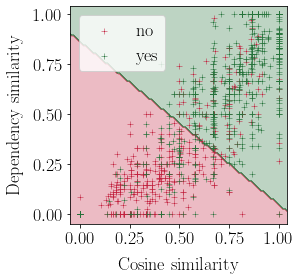

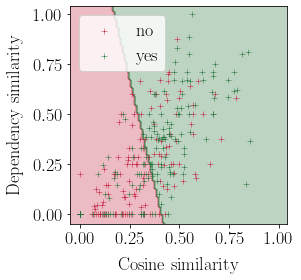

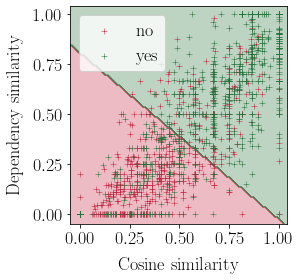

In [31]:
draw_plot(clf_sicknl, vectors_sicknl_test.copy(), gold_sicknl_test)
draw_plot(clf_rte3, vectors_rte3_test.copy(), gold_rte3_test)
draw_plot(clf_merged, vectors_merged_test.copy(), gold_merged_test)

### Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression

params = [{'penalty': ['l1'],
           'C': [0.5, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100],
           'solver': ['saga'],
           'random_state': [1]},
          {'penalty': ['l2'],
           'C': [0.5, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100],
           'solver': ('newton-cg' ,'lbfgs', 'sag', 'saga'),
           'random_state': [1]},
          {'penalty': ['none'],
           'solver': ('newton-cg' ,'lbfgs', 'sag', 'saga'),
           'random_state': [1]}]

clf = LogisticRegression()
clf_sicknl, clf_rte3, clf_merged = train_classifiers(clf, params)

SICK-NL: 0.799 (avg) using {'C': 0.5, 'penalty': 'l1', 'random_state': 1, 'solver': 'saga'}
RTE-3: 0.635 (avg) using {'C': 0.5, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg'}
Merged: 0.754 (avg) using {'C': 0.5, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg'}


In [33]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.798     0.764     0.781       564
           1      0.774     0.807     0.790       564

    accuracy                          0.785      1128
   macro avg      0.786     0.785     0.785      1128
weighted avg      0.786     0.785     0.785      1128

RTE-3 model:
              precision    recall  f1-score   support

           0      0.592     0.641     0.615       156
           1      0.608     0.558     0.582       156

    accuracy                          0.599       312
   macro avg      0.600     0.599     0.599       312
weighted avg      0.600     0.599     0.599       312

Merged model:
              precision    recall  f1-score   support

           0      0.724     0.751     0.738       720
           1      0.742     0.714     0.728       720

    accuracy                          0.733      1440
   macro avg      0.733     0.733     0.733      1440
weighted avg      0.733     0.73

### _k_-NN

In [34]:
from joblib import dump
from sklearn.neighbors import KNeighborsClassifier
import math

params = {'n_neighbors': [round(math.sqrt(len(vectors_sicknl_train))), 
                          round(math.sqrt(len(vectors_rte3_train))), 
                          round(math.sqrt(len(vectors_merged_train)))],
          'weights': ('uniform', 'distance'),
          'leaf_size': [1, 5, 10, 20, 30, 40, 50, 75, 100]
         }

clf = KNeighborsClassifier()
clf_sicknl, clf_rte3, clf_merged = train_classifiers(clf, params)
dump(clf_sicknl, 'models/clf_sicknl.joblib') 
dump(clf_rte3, 'models/clf_rte3.joblib') 
dump(clf_merged, 'models/clf_merged.joblib') 

SICK-NL: 0.806 (avg) using {'leaf_size': 50, 'n_neighbors': 31, 'weights': 'uniform'}
RTE-3: 0.642 (avg) using {'leaf_size': 1, 'n_neighbors': 66, 'weights': 'uniform'}
Merged: 0.755 (avg) using {'leaf_size': 20, 'n_neighbors': 66, 'weights': 'uniform'}


['models/clf_merged.joblib']

In [35]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.782     0.775     0.778       564
           1      0.777     0.784     0.780       564

    accuracy                          0.779      1128
   macro avg      0.779     0.779     0.779      1128
weighted avg      0.779     0.779     0.779      1128

RTE-3 model:
              precision    recall  f1-score   support

           0      0.614     0.622     0.618       156
           1      0.617     0.609     0.613       156

    accuracy                          0.615       312
   macro avg      0.615     0.615     0.615       312
weighted avg      0.615     0.615     0.615       312

Merged model:
              precision    recall  f1-score   support

           0      0.730     0.762     0.746       720
           1      0.751     0.718     0.734       720

    accuracy                          0.740      1440
   macro avg      0.741     0.740     0.740      1440
weighted avg      0.741     0.74

### DTs

In [36]:
from sklearn import tree

params = {'criterion': ('gini', 'entropy'),
          'max_features': ('auto', 'sqrt', 'log2'),
          'random_state': [1],
          'max_depth': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 75, 100, None],
          'min_samples_split': [2, 3, 4, 5, 7, 9, 15],
          'min_samples_leaf': [1, 2, 3]
         }

clf = tree.DecisionTreeClassifier()
clf_sicknl, clf_rte3, clf_merged = train_classifiers(clf, params)

SICK-NL: 0.804 (avg) using {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}
RTE-3: 0.645 (avg) using {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}
Merged: 0.757 (avg) using {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}


In [37]:
eval_classifiers(clf_sicknl, clf_rte3, clf_merged)

SICK-NL model:
              precision    recall  f1-score   support

           0      0.788     0.764     0.776       564
           1      0.771     0.794     0.783       564

    accuracy                          0.779      1128
   macro avg      0.780     0.779     0.779      1128
weighted avg      0.780     0.779     0.779      1128

RTE-3 model:
              precision    recall  f1-score   support

           0      0.579     0.679     0.625       156
           1      0.612     0.506     0.554       156

    accuracy                          0.593       312
   macro avg      0.596     0.593     0.590       312
weighted avg      0.596     0.593     0.590       312

Merged model:
              precision    recall  f1-score   support

           0      0.729     0.765     0.747       720
           1      0.753     0.715     0.734       720

    accuracy                          0.740      1440
   macro avg      0.741     0.740     0.740      1440
weighted avg      0.741     0.74

## Printing interesting pairs

In [38]:
dev_dict_rte3_cosim = pickle.load(open("../data/rte3/dev.p", "rb"))
dev_dict_sicknl_cosim = pickle.load(open("../data/sicknl/dev.p", "rb"))
for pair_id, feats in dev_dict_rte3_cosim.items():
    dev_dict_rte3_cosim[pair_id]['t'] = preprocess(feats['t'], nlp)
    dev_dict_rte3_cosim[pair_id]['h'] = preprocess(feats['h'], nlp)
    
for pair_id, feats in dev_dict_sicknl_cosim.items():
    dev_dict_sicknl_cosim[pair_id]['t'] = preprocess(feats['t'], nlp)
    dev_dict_sicknl_cosim[pair_id]['h'] = preprocess(feats['h'], nlp)
    
dev_dict_rte3_depsim = pickle.load(open("../data/rte3/dev.p", "rb"))
dev_dict_sicknl_depsim = pickle.load(open("../data/sicknl/dev.p", "rb"))

dev_dict_rte3_depsim = append_dict(nlp, dev_dict_rte3_depsim)
dev_dict_sicknl_depsim = append_dict(nlp, dev_dict_sicknl_depsim)

In [39]:
## cosim: 0, depsim: 0, SICK-NL, YES
# for k, v in dev_dict_sicknl_cosim.items():
#     cosim = get_cosim({k: v})
#     depsim = get_depsim(rules_sicknl, {k: dev_dict_sicknl_depsim[k]})
#     if cosim[0] == 0 and depsim[0] == 0 and v['entailment_label'] == 'YES':
#         print(cosim, depsim)
#         print(v['t'])
#         print(v['h'])
#         print(dev_dict_sicknl_depsim[k]['t_tokens'])
#         print(dev_dict_sicknl_depsim[k]['h_tokens'])
#         print(dev_dict_sicknl_depsim[k]['t_deps'])
#         print(dev_dict_sicknl_depsim[k]['h_deps'])

## cosim: 0, depsim: 0, RTE-3
# for k, v in dev_dict_rte3_cosim.items():
#     cosim = get_cosim({k: v})
#     depsim = get_depsim(rules_sicknl, {k: dev_dict_rte3_depsim[k]})
#     if cosim[0] == 0 and depsim[0] == 0:
#         print(cosim, depsim)
#         print(v['t'])
#         print(v['h'])
#         print(dev_dict_rte3_depsim[k]['t_tokens'])
#         print(dev_dict_rte3_depsim[k]['h_tokens'])
#         print(dev_dict_rte3_depsim[k]['t_deps'])
#         print(dev_dict_rte3_depsim[k]['h_deps'])

## Visualising similarities

In [40]:
from random import uniform


def visualise_sims(vectors, gold, target, path):
    """
    Visualises dependency and cosine similarity in a plot.
    
    :param vectors: list of vectors to scatter
    :param gold: list of gold labels
    :param target: 1 for YES, 0 for NO
    :path: path to save plot to
    """
    
    # Add jitter
    for i, vector in enumerate(vectors):
        vectors[i][0] = vectors[i][0] + uniform(0.000, 0.005) - uniform(0.000, 0.005)
        vectors[i][1] = vectors[i][1] + uniform(0.000, 0.005) - uniform(0.000, 0.005)

    X_set, y_set = np.array(vectors), np.array(gold)
    X1, X2 = np.meshgrid(np.arange(start = -0.05, stop = 1.05, step = 0.01),
                         np.arange(start = -0.05, stop = 1.05, step = 0.01))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        if i != target:
            continue
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    s = 30,
                    c = 'black',
                    marker = '+',
                    linewidths = 0.5)

    plt.xlabel('Cosine similarity', labelpad=10)
    plt.ylabel('Dependency similarity', labelpad=10)
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1])
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1])
    plt.gca().set_aspect('equal')
    plt.savefig(path, bbox_inches='tight')
    plt.show()

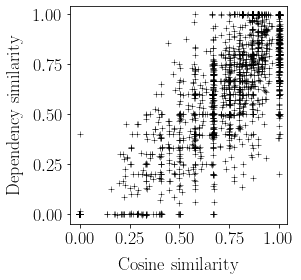

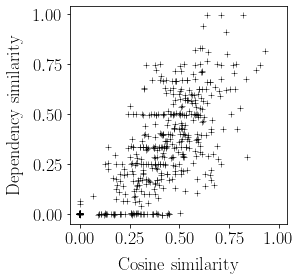

In [41]:
visualise_sims(vectors_sicknl_train.copy(), gold_sicknl_train, 1, 'sicknl_train_y.pdf')
visualise_sims(vectors_rte3_train.copy(), gold_rte3_train, 1, 'rte3_train_y.pdf')

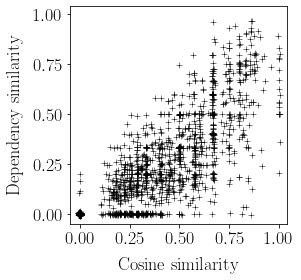

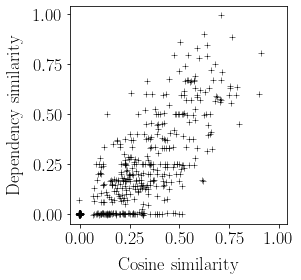

In [42]:
visualise_sims(vectors_sicknl_train.copy(), gold_sicknl_train, 0, 'sicknl_train_n.pdf')
visualise_sims(vectors_rte3_train.copy(), gold_rte3_train, 0, 'rte3_train_n.pdf')